In [2]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Dropout
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint, Callback
import matplotlib.pyplot as plt


In [3]:
# Enable mixed precision training
from tensorflow.keras.mixed_precision import set_global_policy
set_global_policy('mixed_float16')

In [4]:
# Check for mixed precision support
physical_devices = tf.config.list_physical_devices('GPU')
if physical_devices:
    gpu_device = physical_devices[0]
    # Mixed precision support is checked by default by TensorFlow
    print("Mixed precision training assumed to be supported if GPU supports it. Ensure compatible TensorFlow version.")
else:
    print("No GPU detected. Mixed precision training will not be effective on CPU.")


No GPU detected. Mixed precision training will not be effective on CPU.


In [5]:
# Load and preprocess data
data = pd.read_csv('Processed_dataset.csv')

In [6]:
# Handle missing values
if data.isnull().sum().any():
    print("Dataset contains missing values. Applying imputation.")
    data.fillna(data.mean(), inplace=True)  # Simple mean imputation; adjust as needed for your dataset


In [7]:

# Normalize the data
scaler = StandardScaler()
X_train, X_val = train_test_split(data, test_size=0.2, random_state=42)
X_train_normalized = scaler.fit_transform(X_train)
X_val_normalized = scaler.transform(X_val)


In [8]:
# Input dimensions
input_dim = X_train_normalized.shape[1]


In [9]:
# GPU setup
if physical_devices:
    try:
        tf.config.set_logical_device_configuration(
            physical_devices[0],
            [tf.config.LogicalDeviceConfiguration(memory_limit=10240)]  # Set memory limit in MB if needed
        )
        print("GPU is available and will be used.")
    except RuntimeError as e:
        print("Error configuring GPU memory:", e)
else:
    print("GPU not available. Falling back to CPU.")


GPU not available. Falling back to CPU.


In [10]:
# Define the autoencoder model
def create_autoencoder(encoding_dim=16):
    input_layer = Input(shape=(input_dim,))
    encoded = Dense(128, activation='relu', kernel_regularizer=l2(0.001))(input_layer)
    encoded = Dropout(0.2)(encoded)
    encoded = Dense(64, activation='relu', kernel_regularizer=l2(0.001))(encoded)
    encoded = Dense(encoding_dim, activation='relu', kernel_regularizer=l2(0.001))(encoded)

    decoded = Dense(64, activation='relu', kernel_regularizer=l2(0.001))(encoded)
    decoded = Dense(128, activation='relu', kernel_regularizer=l2(0.001))(decoded)
    decoded = Dense(input_dim, activation='sigmoid', kernel_regularizer=l2(0.001))(decoded)

    autoencoder = Model(inputs=input_layer, outputs=decoded)
    return autoencoder

In [11]:
# Initialize autoencoder
autoencoder = create_autoencoder(encoding_dim=16)


In [12]:
# Compile the model
autoencoder.compile(optimizer='adam', loss='mse')


In [13]:





# Define callbacks
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=3,
    min_lr=1e-6,
    verbose=1
)

class LoggingLearningRateCallback(Callback):
    def on_epoch_end(self, epoch, logs=None):
        lr = tf.keras.backend.get_value(self.model.optimizer.learning_rate)
        print(f"Epoch {epoch + 1}: Learning rate is {lr}")

logging_lr_callback = LoggingLearningRateCallback()

model_checkpoint = ModelCheckpoint(
    filepath='best_autoencoder.keras',
    monitor='val_loss',
    save_best_only=True,
    verbose=1
)



In [14]:
# Create optimized data pipeline
train_dataset = tf.data.Dataset.from_tensor_slices((X_train_normalized, X_train_normalized))
train_dataset = train_dataset.shuffle(buffer_size=2048).batch(256).prefetch(tf.data.AUTOTUNE)  # Adjusted buffer size and batch size

val_dataset = tf.data.Dataset.from_tensor_slices((X_val_normalized, X_val_normalized)).batch(256)


In [15]:
# Train the model
history = autoencoder.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=100,
    callbacks=[early_stopping, reduce_lr, model_checkpoint, logging_lr_callback]
)

Epoch 1/100
310/313 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 1.2176
Epoch 1: val_loss improved from inf to 0.93668, saving model to best_autoencoder.keras
Epoch 1: Learning rate is 0.0010000000474974513
313/313 ━━━━━━━━━━━━━━━━━━━━ 20s 25ms/step - loss: 1.2156 - val_loss: 0.9367 - learning_rate: 0.0010
Epoch 2/100
312/313 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.9242
Epoch 2: val_loss improved from 0.93668 to 0.91879, saving model to best_autoencoder.keras
Epoch 2: Learning rate is 0.0010000000474974513
313/313 ━━━━━━━━━━━━━━━━━━━━ 7s 22ms/step - loss: 0.9241 - val_loss: 0.9188 - learning_rate: 0.0010
Epoch 3/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.9098
Epoch 3: val_loss improved from 0.91879 to 0.91051, saving model to best_autoencoder.keras
Epoch 3: Learning rate is 0.0010000000474974513
313/313 ━━━━━━━━━━━━━━━━━━━━ 7s 21ms/step - loss: 0.9098 - val_loss: 0.9105 - learning_rate: 0.0010
Epoch 4/100
312/313 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.9015
Epoch 4: v

In [17]:
# Extract loss values
train_loss = history.history['loss']
val_loss = history.history['val_loss']


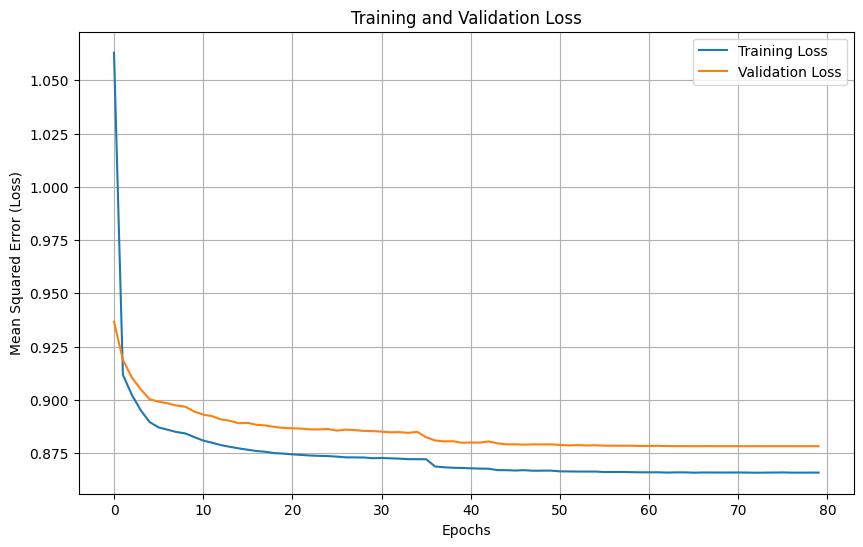

In [18]:

# Plot the training and validation loss
plt.figure(figsize=(10, 6))
plt.plot(train_loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Mean Squared Error (Loss)')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True)
plt.show()